# Biogeochemistry-Informed Neural Network (BINN)
Adapted from the [BINN GitHub repository](https://github.com/Hardyxu8067/BINN) and the accompanying manuscript: [arXiv:2502.00672](https://arxiv.org/abs/2502.00672).
#####  
**Goal of this demo**  
Learn how to (1) use BINN to improve a process‑based model’s predictive skill and (2) interpret the learned parameters for scientific insight.  
#####  
**Recall of BINN Structure**  
BINN embeds a process‑based model inside a deep‑learning framework so its parameterization can be optimized from data. In this demo, the embedded process model is the soil‑organic‑carbon (SOC) module from CLM5 (Community Land Model v5, UCAR/NCAR). Here we provide a vectorized PyTorch re‑implementation of the matrix form of CLM5: <span style="color:DarkCyan">*./fun_matrix_clm5_vectorized.py*</span>  
To apply BINN in other domains, replace this CLM5 model with your target process-based model and provide the corresponding inputs/data. 

## Required Environment & dependencies
The key packages to install are PyTorch, Numpy, Scipy, Pandas, matplotlib, scikit-learn, and cartopy. 

In [1]:
#-------------------------------
# Import the required libraries
#-------------------------------
import time
import random
from datetime import datetime, timedelta
# Set HDF5_DISABLE_VERSION_CHECK to suppress version mismatch error
import os
os.environ['HDF5_DISABLE_VERSION_CHECK'] = '2'

import pandas as pd
from pandas import DataFrame as df
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat
from collections import OrderedDict

import torch
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Import Vectorized Versions of CLM5
from fun_matrix_clm5_vectorized import fun_model_simu, fun_model_prediction
from fun_matrix_clm5_vectorized_bulk_converge import fun_bulk_simu

print(datetime.now(), '------------all packages loaded------------')

2025-07-31 12:12:49.434385 ------------all packages loaded------------


## What to edit here
Use this cell to name your experiment, point to your data/output folders, and set training hyperparameters:  
#####  
**model_name** — the name of the process-based model.  
**data_dir_input** — folder where your input data live.  
**data_dir_output** — folder where results (checkpoints, logs, figures) will be saved.  
**n_samples** — number of samples to use for this demo (which will affect the run time).  
**Training hyperparameters**: val_split_ratio, test_split_ratio, emb_dim, lr, batch_size, num_epoch, weight_decay, scheduler_step_size, scheduler_gamma, patience.  
**seed** — random seed for (approximate) reproducibility.  

In [2]:
################################################
# Input Hyperparameters
################################################
model_name = 'cesm2_clm5_cen_vr_v2'
data_dir_input = './Input_Data/'
data_dir_output = './Output_Data/'

# NN model parameters
n_samples = 200
val_split_ratio = 0.1
test_split_ratio = 0.1
emb_dim = 50
lr = 1e-3
batch_size = 16
num_epoch = 100
weight_decay = 0
scheduler_step_size = 1000
scheduler_gamma = 0
patience = 500
seed = 111

# Set random seeds to try to ensure reproducibility
def set_seeds(seed):
	random.seed(seed)
	np.random.seed(seed)
	torch.manual_seed(seed)
	if torch.cuda.is_available():
		torch.cuda.manual_seed(seed)
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = True
set_seeds(seed)

# Define the job ID
job_id = time.strftime("%Y%m%d-%H%M%S")
job_id += ("_" + model_name)
print(f"New job ID: {job_id}")

# Define the device
# Here CPU is enough
device = "cpu"

# Create output directories
os.makedirs(data_dir_output, exist_ok=True)
os.makedirs(os.path.join(data_dir_output, job_id), exist_ok=True)

New job ID: 20250731-121252_cesm2_clm5_cen_vr_v2


## CLM5 constants, parameters, forcing data, and other input data. 
This cell defines:  
**(A)** CLM5 constants  
**(B)** CLM5 trainable parameters  
**(C)** the observational and forcing data that BINN loads for training. For this demo, all inputs are a subset of sites from New York State, extracted from the larger global datasets.

In [3]:
#-------------------------------
# CLM5 constants
#-------------------------------
month_num = 12 
soil_cpool_num = 7
soil_decom_num = 20

# parameters names
para_names = ['diffus', 'cryo', 'q10', 'efolding', \
			  'taucwd', 'taul1', 'taul2', 'tau4s1', 'tau4s2', 'tau4s3', \
			  'fl1s1', 'fl2s1', 'fl3s2', 'fs1s2', 'fs1s3', 'fs2s1', 'fs2s3', 'fs3s1', 'fcwdl2', \
			  'w-scaling', 'beta']
para_index = np.arange(len(para_names))

# soil depths info
# width between two interfaces
dz = np.array([2.000000000000000E-002, 4.000000000000000E-002, 6.000000000000000E-002, \
8.000000000000000E-002, 0.120000000000000, 0.160000000000000, \
0.200000000000000, 0.240000000000000, 0.280000000000000, \
0.320000000000000, 0.360000000000000, 0.400000000000000, \
0.440000000000000, 0.540000000000000, 0.640000000000000, \
0.740000000000000, 0.840000000000000, 0.940000000000000, \
1.04000000000000, 1.14000000000000, 2.39000000000000, \
4.67553390593274, 7.63519052838329, 11.1400000000000, \
15.1154248593737])

# depth of the interface
zisoi = np.array([2.000000000000000E-002, 6.000000000000000E-002, \
0.120000000000000, 0.200000000000000, 0.320000000000000, \
0.480000000000000, 0.680000000000000, 0.920000000000000, \
1.20000000000000, 1.52000000000000, 1.88000000000000, \
2.28000000000000, 2.72000000000000, 3.26000000000000, \
3.90000000000000, 4.64000000000000, 5.48000000000000, \
6.42000000000000, 7.46000000000000, 8.60000000000000, \
10.9900000000000, 15.6655339059327, 23.3007244343160, \
34.4407244343160, 49.5561492936897])

zisoi_0 = 0

# depth of the node
zsoi = np.array([1.000000000000000E-002, 4.000000000000000E-002, 9.000000000000000E-002, \
0.160000000000000, 0.260000000000000, 0.400000000000000, \
0.580000000000000, 0.800000000000000, 1.06000000000000, \
1.36000000000000, 1.70000000000000, 2.08000000000000, \
2.50000000000000, 2.99000000000000, 3.58000000000000, \
4.27000000000000, 5.06000000000000, 5.95000000000000, \
6.94000000000000, 8.03000000000000, 9.79500000000000, \
13.3277669529664, 19.4831291701244, 28.8707244343160, \
41.9984368640029])

# depth between two node
dz_node = zsoi - np.append(np.array([0]), zsoi[:-1], axis = 0)

# cesm2 resolution
cesm2_resolution_lat = 180/384
cesm2_resolution_lon = 360/576
lon_grid = np.arange((-180 + cesm2_resolution_lon/2), 180, cesm2_resolution_lon)
lat_grid = np.arange((90 - cesm2_resolution_lat/2), -90, -cesm2_resolution_lat)

#-------------------------------
# Load the data
#-------------------------------
# SOC observations
profile_collection = np.loadtxt(os.path.join(data_dir_input, 'Training_Data', 'profile_id.txt'), delimiter=',')
original_profile_num = len(profile_collection)
obs_soc_matrix = np.loadtxt(os.path.join(data_dir_input, 'Training_Data', 'obs_soc_NY.txt'), delimiter=',')
obs_soc_depth = np.loadtxt(os.path.join(data_dir_input, 'Training_Data', 'obs_soc_depth.txt'), delimiter=',')
profile_id = np.arange(len(profile_collection))
print(original_profile_num, 'profiles loaded')

# Environmental information at each site
env_info = np.loadtxt(os.path.join(data_dir_input, 'Training_Data', 'env_info.txt'), delimiter=',')
col_max_min = np.loadtxt(os.path.join(data_dir_input, 'Training_Data', 'col_max_min.txt'), delimiter=',')

# Process-based model input data (forcing data) at each site
# Carbon Input
model_force_input_vector_cwd = np.loadtxt(os.path.join(data_dir_input, 'Training_Data', 'model_force_input_vector_cwd.txt'), delimiter=',')
model_force_input_vector_litter1 = np.loadtxt(os.path.join(data_dir_input, 'Training_Data', 'model_force_input_vector_litter1.txt'), delimiter=',')
model_force_input_vector_litter2 = np.loadtxt(os.path.join(data_dir_input, 'Training_Data', 'model_force_input_vector_litter2.txt'), delimiter=',')
model_force_input_vector_litter3 = np.loadtxt(os.path.join(data_dir_input, 'Training_Data', 'model_force_input_vector_litter3.txt'), delimiter=',')
# Max Active Layer Depth
model_force_altmax_lastyear_profile = np.loadtxt(os.path.join(data_dir_input, 'Training_Data', 'model_force_altmax_lastyear_profile.txt'), delimiter=',')
model_force_altmax_current_profile = np.loadtxt(os.path.join(data_dir_input, 'Training_Data', 'model_force_altmax_current_profile.txt'), delimiter=',')
# Bedrock Layer
model_force_nbedrock = np.loadtxt(os.path.join(data_dir_input, 'Training_Data', 'model_force_nbedrock.txt'), delimiter=',')
# Oxygen Scalar
model_force_xio = np.load(os.path.join(data_dir_input, 'Training_Data', 'model_force_xio.npy'), allow_pickle=True)
# Nitrogen Scalar
model_force_xin = np.load(os.path.join(data_dir_input, 'Training_Data', 'model_force_xin.npy'), allow_pickle=True)
# Sand Content
model_force_sand_vector = np.load(os.path.join(data_dir_input, 'Training_Data', 'model_force_sand_vector.npy'), allow_pickle=True)
# Soil Temperature
model_force_soil_temp_profile = np.load(os.path.join(data_dir_input, 'Training_Data', 'model_force_soil_temp_profile.npy'), allow_pickle=True)
# Soil Moisture
model_force_soil_water_profile = np.load(os.path.join(data_dir_input, 'Training_Data', 'model_force_soil_water_profile.npy'), allow_pickle=True)

# Randomly select a subset of n_samples profiles for testing
sample_profile_id = profile_id[np.random.choice(len(profile_id), n_samples, replace=False)]
profile_collection = profile_collection[sample_profile_id]
profile_id = profile_id[sample_profile_id]
obs_soc_matrix = obs_soc_matrix[sample_profile_id, :]
obs_soc_depth = obs_soc_depth[sample_profile_id, :]
env_info = env_info[sample_profile_id, :]
model_force_input_vector_cwd = model_force_input_vector_cwd[sample_profile_id, :]
model_force_input_vector_litter1 = model_force_input_vector_litter1[sample_profile_id, :]
model_force_input_vector_litter2 = model_force_input_vector_litter2[sample_profile_id, :]
model_force_input_vector_litter3 = model_force_input_vector_litter3[sample_profile_id, :]
model_force_altmax_lastyear_profile = model_force_altmax_lastyear_profile[sample_profile_id, :]
model_force_altmax_current_profile = model_force_altmax_current_profile[sample_profile_id, :]
model_force_nbedrock = model_force_nbedrock[sample_profile_id, :]
model_force_xio = model_force_xio[sample_profile_id, :]
model_force_xin = model_force_xin[sample_profile_id, :]
model_force_sand_vector = model_force_sand_vector[sample_profile_id, :]
model_force_soil_temp_profile = model_force_soil_temp_profile[sample_profile_id, :]
model_force_soil_water_profile = model_force_soil_water_profile[sample_profile_id, :]

print(datetime.now(), '------------all input data loaded with profile number:', len(profile_collection), '------------')

1406 profiles loaded
2025-07-31 12:12:57.299592 ------------all input data loaded with profile number: 200 ------------


## Environmental Inputs and Prediction Data

This cell scales continuous environmental variables to [0,1] using `col_max_min` (leaving categorical variables untransformed and preserving original `Lon`/`Lat`).  
Then, the New York–state gridded prediction inputs are loaded (environmental covariates, CLM5 forcing data).  
These data 

In [4]:
#---------------------------------------------------
# Normalize env info (Input data)
#---------------------------------------------------
# environmental info names
var4nn = ['Lon', 'Lat', \
'ESA_Land_Cover', \
'BIO1', 'BIO2', 'BIO3', 'BIO4', 'BIO12', 'BIO15', \
'Bulk_Density_0cm', 'Bulk_Density_30cm', 'Bulk_Density_100cm',\
'CEC_0cm', 'CEC_30cm', 'CEC_100cm', \
'Clay_Content_0cm', 'Clay_Content_30cm', 'Clay_Content_100cm', \
'Coarse_Fragments_v_0cm', 'Coarse_Fragments_v_30cm', 'Coarse_Fragments_v_100cm', \
'pH_Water_0cm', 'pH_Water_30cm', 'pH_Water_100cm', \
'Silt_Content_0cm', 'Silt_Content_30cm', 'Silt_Content_100cm', \
'SWC_v_Wilting_Point_0cm', 'SWC_v_Wilting_Point_30cm', 'SWC_v_Wilting_Point_100cm', \
'Texture_USDA_0cm', 'Texture_USDA_30cm', 'Texture_USDA_100cm', \
'USDA_Suborder', \
'WRB_Subgroup', \
'Elevation', \
'Koppen_Climate_2018', \
'nbedrock']
# Categorical variables
categorical_vars = [['ESA_Land_Cover'], ['Texture_USDA_0cm', 'Texture_USDA_30cm', 'Texture_USDA_100cm'], 
					['USDA_Suborder'], ['WRB_Subgroup']]  # Variables inside a sub-list share the same categories
categorical_vars_flattened = [item for sublist in categorical_vars for item in sublist]

# Store the original longitude and latitude values
original_lons = env_info[:, 0].copy()
original_lats = env_info[:, 1].copy()

# Don't want to transform categorical variables, so set max/min to nan
for group in categorical_vars:
	for var in group:
		idx = var4nn.index(var)
		col_max_min[idx, :] = np.nan

# Normalize the environmental information
# Skip the longitude and latitude columns
for ivar in np.arange(2, len(col_max_min[:, 0])):
	if np.isnan(col_max_min[ivar, :]).any():
		pass
	else:
		env_info[:, ivar] = (env_info[:, ivar] - col_max_min[ivar, 0])/(col_max_min[ivar, 1] - col_max_min[ivar, 0])
		env_info[(env_info[:, ivar] > 1), ivar] = 1
		env_info[(env_info[:, ivar] < 0), ivar] = 0

env_info = df(env_info)
env_info.columns = var4nn

print(datetime.now(), '------------Finish processing input data------------')

2025-07-31 01:20:17.396425 ------------Finish processing input data------------


In [5]:
#---------------------------------------------------
# Load Data for Prediction
#--------------------------------------------------- 
grid_env_info_ID = np.loadtxt(os.path.join(data_dir_input, 'Prediction_Data', 'grid_env_info_ID.txt'), delimiter=',')
grid_env_info_NY = np.loadtxt(os.path.join(data_dir_input, 'Prediction_Data', 'grid_env_info_NY.txt'), delimiter=',')
model_force_pred_input_vector_cwd = np.loadtxt(os.path.join(data_dir_input, 'Prediction_Data', 'model_force_pred_input_vector_cwd.txt'), delimiter=',')
model_force_pred_input_vector_litter1 = np.loadtxt(os.path.join(data_dir_input, 'Prediction_Data', 'model_force_pred_input_vector_litter1.txt'), delimiter=',')
model_force_pred_input_vector_litter2 = np.loadtxt(os.path.join(data_dir_input, 'Prediction_Data', 'model_force_pred_input_vector_litter2.txt'), delimiter=',')
model_force_pred_input_vector_litter3 = np.loadtxt(os.path.join(data_dir_input, 'Prediction_Data', 'model_force_pred_input_vector_litter3.txt'), delimiter=',')
model_force_pred_altmax_lastyear_profile = np.loadtxt(os.path.join(data_dir_input, 'Prediction_Data', 'model_force_pred_altmax_lastyear_profile.txt'), delimiter=',')
model_force_pred_altmax_current_profile = np.loadtxt(os.path.join(data_dir_input, 'Prediction_Data', 'model_force_pred_altmax_current_profile.txt'), delimiter=',')
model_force_pred_nbedrock = np.loadtxt(os.path.join(data_dir_input, 'Prediction_Data', 'model_force_pred_nbedrock.txt'), delimiter=',')
model_force_pred_xio = np.load(os.path.join(data_dir_input, 'Prediction_Data', 'model_force_pred_xio.npy'), allow_pickle=True)
model_force_pred_xin = np.load(os.path.join(data_dir_input, 'Prediction_Data', 'model_force_pred_xin.npy'), allow_pickle=True)
model_force_pred_sand_vector = np.load(os.path.join(data_dir_input, 'Prediction_Data', 'model_force_pred_sand_vector.npy'), allow_pickle=True)
model_force_pred_soil_temp_profile = np.load(os.path.join(data_dir_input, 'Prediction_Data', 'model_force_pred_soil_temp_profile.npy'), allow_pickle=True)
model_force_pred_soil_water_profile = np.load(os.path.join(data_dir_input, 'Prediction_Data', 'model_force_pred_soil_water_profile.npy'), allow_pickle=True)

# Normalize the environmental information
# Skip the longitude and latitude columns
for ivar in np.arange(2, len(col_max_min[:, 0])):
	if np.isnan(col_max_min[ivar, :]).any():
		pass
	else:
		grid_env_info_NY[:, ivar] = (grid_env_info_NY[:, ivar] - col_max_min[ivar, 0])/(col_max_min[ivar, 1] - col_max_min[ivar, 0])
		grid_env_info_NY[(grid_env_info_NY[:, ivar] > 1), ivar] = 1
		grid_env_info_NY[(grid_env_info_NY[:, ivar] < 0), ivar] = 0
		
grid_env_info_NY = df(grid_env_info_NY)
grid_env_info_NY.columns = var4nn
grid_lon = grid_env_info_NY['Lon'].values
grid_lat = grid_env_info_NY['Lat'].values

# Check the max and min value of categorical variables, if it is larger than the number of categories, then remove the row
for group in categorical_vars:
	mask_max = grid_env_info_NY[group].apply(lambda x: (x > np.max(env_info[group])).any(), axis=1)
	mask_min = grid_env_info_NY[group].apply(lambda x: (x < np.min(env_info[group])).any(), axis=1)
	mask = mask_max | mask_min
	indices_to_remove = grid_env_info_NY[mask].index
	grid_env_info_NY = grid_env_info_NY.drop(indices_to_remove)
	grid_env_info_ID = grid_env_info_ID[~mask]
	model_force_pred_input_vector_cwd = model_force_pred_input_vector_cwd[~mask, :]
	model_force_pred_input_vector_litter1 = model_force_pred_input_vector_litter1[~mask, :]
	model_force_pred_input_vector_litter2 = model_force_pred_input_vector_litter2[~mask, :]
	model_force_pred_input_vector_litter3 = model_force_pred_input_vector_litter3[~mask, :]
	model_force_pred_altmax_lastyear_profile = model_force_pred_altmax_lastyear_profile[~mask, :]
	model_force_pred_altmax_current_profile = model_force_pred_altmax_current_profile[~mask, :]
	model_force_pred_nbedrock = model_force_pred_nbedrock[~mask, :]	
	model_force_pred_xio = model_force_pred_xio[~mask]
	model_force_pred_xin = model_force_pred_xin[~mask]
	model_force_pred_sand_vector = model_force_pred_sand_vector[~mask]
	model_force_pred_soil_temp_profile = model_force_pred_soil_temp_profile[~mask]
	model_force_pred_soil_water_profile = model_force_pred_soil_water_profile[~mask]
	grid_lon = grid_lon[~mask]
	grid_lat = grid_lat[~mask]


print(f'Number of grid points in NY State: {len(grid_env_info_NY)}')
print('-----------------------Finish processing prediction data-----------------------')

Number of grid points in NY State: 131
-----------------------Finish processing prediction data-----------------------


In [6]:
#---------------------------------------------------
# Organize training data
#---------------------------------------------------
# Remove the 'Lon' and 'Lat' columns from var4nn
var4nn = [var for var in var4nn if var not in ['Lon', 'Lat']] 

# Environmental information and Model forcing data
current_data_x = np.ones((len(profile_collection),  max(len(var4nn), 20), 12, 13))*np.nan
current_data_x[:, 0:len(var4nn), 0, 0] = env_info[var4nn]
current_data_x[:, 0:12, 0, 1] = model_force_input_vector_cwd
current_data_x[:, 0:12, 0, 2] = model_force_input_vector_litter1
current_data_x[:, 0:12, 0, 3] = model_force_input_vector_litter2
current_data_x[:, 0:12, 0, 4] = model_force_input_vector_litter3
current_data_x[:, 0:12, 0, 5] = model_force_altmax_lastyear_profile
current_data_x[:, 0:12, 0, 6] = model_force_altmax_current_profile
current_data_x[:, 0:12, 0, 7] = model_force_nbedrock

current_data_x[:, 0:20, 0:12, 8] = model_force_xio
current_data_x[:, 0:20, 0:12, 9] = model_force_xin
current_data_x[:, 0:20, 0:12, 10] = model_force_sand_vector
current_data_x[:, 0:20, 0:12, 11] = model_force_soil_temp_profile
current_data_x[:, 0:20, 0:12, 12] = model_force_soil_water_profile

# Include SOC data in current_data_y
current_data_y = obs_soc_matrix

# Include SOC depth in current_data_z
current_data_z = obs_soc_depth

# Check if there're any negative values in the data
print("Negative values in current_data_y", np.sum(current_data_y < 0))

lons = original_lons
lats = original_lats

nan_loc = np.sum(current_data_x[:, 0:len(var4nn), 0, 0], axis = 1) + \
			np.sum(model_force_input_vector_cwd, axis = 1) + \
			np.sum(model_force_input_vector_litter1, axis = 1) + \
			np.sum(model_force_input_vector_litter2, axis = 1) + \
			np.sum(model_force_input_vector_litter3, axis = 1) + \
			np.sum(model_force_altmax_lastyear_profile, axis = 1) + \
			np.sum(model_force_altmax_current_profile, axis = 1) + \
			np.sum(model_force_nbedrock, axis = 1) + \
			np.sum(model_force_xio, axis = (1, 2)) + \
			np.sum(model_force_xin, axis = (1, 2)) + \
			np.sum(model_force_sand_vector, axis = (1, 2)) + \
			np.sum(model_force_soil_temp_profile, axis = (1, 2)) + \
			np.sum(model_force_soil_water_profile, axis = (1, 2)) 

nan_mask = ~np.isnan(nan_loc)

neg_mask = ~np.any(current_data_y < 0, axis=1)

valid_profile_loc = np.where(nan_mask & neg_mask)[0]

current_data_y = current_data_y[valid_profile_loc, :]
current_data_z = current_data_z[valid_profile_loc, :]
current_data_x = current_data_x[valid_profile_loc, :, :, :]
current_profile_collection = profile_collection[valid_profile_loc]
current_profile_id = profile_id[valid_profile_loc]
lons = lons[valid_profile_loc]
lats = lats[valid_profile_loc]

print("Shape of current data x", current_data_x.shape)
print("Shape of current data y", current_data_y.shape)
print("Shape of current data z", current_data_z.shape)
print("Shape of current data profile_id", current_profile_collection.shape)
print("Shape of current data profile_id", current_profile_id.shape)
print("Shape of lons", lons.shape)
print("Shape of lats", lats.shape)
print("Negative values in current_data_y", np.sum(current_data_y < 0))

# Prediction data
predict_data_x = np.ones((len(grid_env_info_ID), max(len(var4nn), 20), 12, 13))*np.nan
predict_data_x[:, 0:len(var4nn), 0, 0] = grid_env_info_NY[var4nn]
predict_data_x[:, 0:12, 0, 1] = model_force_pred_input_vector_cwd
predict_data_x[:, 0:12, 0, 2] = model_force_pred_input_vector_litter1
predict_data_x[:, 0:12, 0, 3] = model_force_pred_input_vector_litter2
predict_data_x[:, 0:12, 0, 4] = model_force_pred_input_vector_litter3
predict_data_x[:, 0:12, 0, 5] = model_force_pred_altmax_lastyear_profile
predict_data_x[:, 0:12, 0, 6] = model_force_pred_altmax_current_profile
predict_data_x[:, 0:12, 0, 7] = model_force_pred_nbedrock
predict_data_x[:, 0:20, 0:12, 8] = model_force_pred_xio
predict_data_x[:, 0:20, 0:12, 9] = model_force_pred_xin
predict_data_x[:, 0:20, 0:12, 10] = model_force_pred_sand_vector
predict_data_x[:, 0:20, 0:12, 11] = model_force_pred_soil_temp_profile
predict_data_x[:, 0:20, 0:12, 12] = model_force_pred_soil_water_profile

# Create a dummy depth array for prediction
predict_data_z = np.zeros((len(grid_env_info_ID), 200))

nan_loc_pred = np.sum(predict_data_x[:, 0:len(var4nn), 0, 0], axis = 1) + \
			np.sum(model_force_pred_input_vector_cwd, axis = 1) + \
			np.sum(model_force_pred_input_vector_litter1, axis = 1) + \
			np.sum(model_force_pred_input_vector_litter2, axis = 1) + \
			np.sum(model_force_pred_input_vector_litter3, axis = 1) + \
			np.sum(model_force_pred_altmax_lastyear_profile, axis = 1) + \
			np.sum(model_force_pred_altmax_current_profile, axis = 1) + \
			np.sum(model_force_pred_nbedrock, axis = 1) + \
			np.sum(model_force_pred_xio, axis = (1, 2)) + \
			np.sum(model_force_pred_xin, axis = (1, 2)) + \
			np.sum(model_force_pred_sand_vector, axis = (1, 2))
nan_mask_pred = ~np.isnan(nan_loc_pred)

predict_data_x = predict_data_x[nan_mask_pred, :, :, :]
predict_data_z = predict_data_z[nan_mask_pred, :]
grid_lat = grid_lat[nan_mask_pred]
grid_lon = grid_lon[nan_mask_pred]


## Train, validation, test split
# Determine the number of training samples based on the ratios
train_loc = np.random.choice(np.arange(0, len(current_data_x[:, 0])), size=round((1 - val_split_ratio - test_split_ratio) * len(current_data_x[:, 0])), replace=False)
# The remaining data after removing the training samples
remaining_loc = np.setdiff1d(np.arange(0, len(current_data_x[:, 0])), train_loc)
# Split the remaining data into validation and test sets
num_val_samples = round(val_split_ratio / (val_split_ratio + test_split_ratio) * len(remaining_loc))
val_loc = np.random.choice(remaining_loc, size=num_val_samples, replace=False)
test_loc = np.setdiff1d(remaining_loc, val_loc)

train_y = torch.tensor(current_data_y[train_loc, :], dtype=torch.float32)
val_y = torch.tensor(current_data_y[val_loc, :], dtype=torch.float32)
test_y = torch.tensor(current_data_y[test_loc, :], dtype=torch.float32)

train_z = torch.tensor(current_data_z[train_loc, :], dtype=torch.float32)
val_z = torch.tensor(current_data_z[val_loc, :], dtype=torch.float32)
test_z = torch.tensor(current_data_z[test_loc, :], dtype=torch.float32)

train_x = torch.tensor(current_data_x[train_loc, :, :, :], dtype=torch.float32)
val_x = torch.tensor(current_data_x[val_loc, :, :, :], dtype=torch.float32)
test_x = torch.tensor(current_data_x[test_loc, :, :, :], dtype=torch.float32)

train_profile_id = torch.tensor(current_profile_id[train_loc], dtype=torch.long)
val_profile_id = torch.tensor(current_profile_id[val_loc], dtype=torch.long)
test_profile_id = torch.tensor(current_profile_id[test_loc], dtype=torch.long)


print(datetime.now(), '------------nn data prepared------------')

Negative values in current_data_y 0
Shape of current data x (191, 36, 12, 13)
Shape of current data y (191, 200)
Shape of current data z (191, 200)
Shape of current data profile_id (191,)
Shape of current data profile_id (191,)
Shape of lons (191,)
Shape of lats (191,)
Negative values in current_data_y 0
2025-07-31 01:20:17.722058 ------------nn data prepared------------


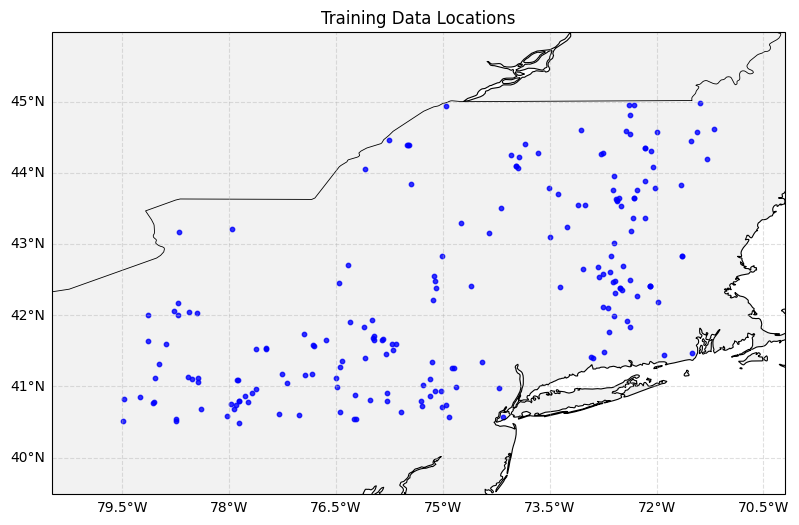

In [7]:
# Plot the map of the training data
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())      
ax.set_global()                                  
ax.add_feature(cfeature.LAND, facecolor='0.95', zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=0)
ax.coastlines(linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.6)
ax.scatter(lons, lats,
           s=10, c='blue', alpha=0.8,
           transform=ccrs.PlateCarree())
margin = 1
ax.set_extent([lons.min()-margin, lons.max()+margin,
               lats.min()-margin, lats.max()+margin],
              crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.4)
gl.right_labels = False
gl.top_labels = False
plt.title('Training Data Locations')
plt.show()


## Distribution of SOC data along the soil depths
While CLM5 simulates SOC dynamics at 20 specific depths, SOC data collected from the field were not necessarily measured at the depth nodes set in CLM5 simulation.  
**(A)** Thus, in calculating the loss function value, for observations at depths equaling CLM5 nodes, the simulated values were directly from CLM5 outputs.  
**(B)** When observations occur at depths between two CLM5 nodes, we employed linear interpolation to estimate simulated SOC values at the observation depths.  
**(C)** In cases where observations extend beyond 8 meters (i.e., the deepest node in CLM5 simulations), we used the values at 8 meters as simulated SOC as SOC concentration in deeper layers no longer changes much.  

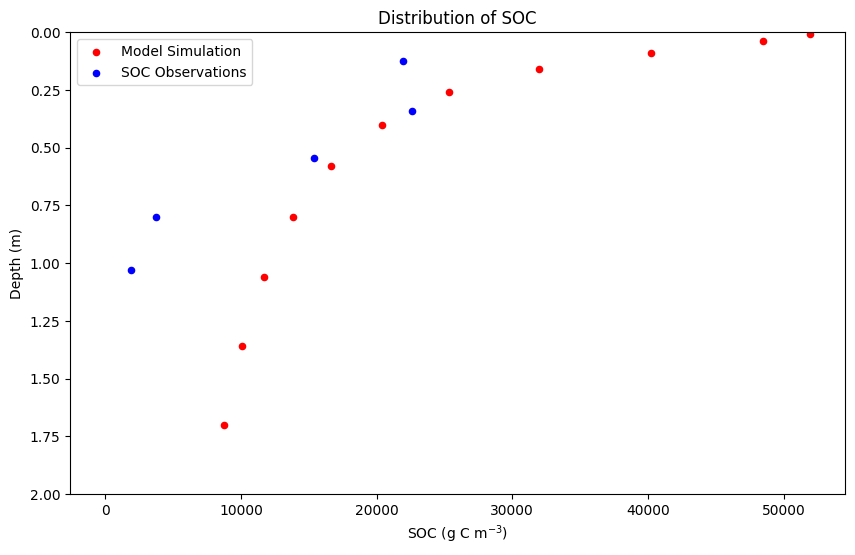

In [8]:
# Model Simulation of SOC looks like
iprofile = 3
# assume parameters all at the mean value (0.5 for all 21 parameters)
temp_para = torch.tensor([0.5] * 21, dtype=torch.float32, device=device).unsqueeze(0)
simu_soc_temp = fun_model_prediction(temp_para, torch.tensor(current_data_x[iprofile, :, :, :]).unsqueeze(0), soil_decom_num)

plt.figure(figsize=(10, 6))
# SOC Simulation
plt.scatter(simu_soc_temp[:, 0:20], zsoi[0:20], s=20, alpha=1, color='red')
# SOC Observations
plt.scatter(obs_soc_matrix[iprofile,], obs_soc_depth[iprofile,], s=20, alpha=1, color='blue')
plt.title('Distribution of SOC')
plt.xlabel('SOC (g C m$^{-3}$)')
plt.ylabel('Depth (m)')
plt.ylim(0, 2)
plt.gca().invert_yaxis()
plt.legend(['Model Simulation', 'SOC Observations'])

## Loss Function and BINN Structure
**Loss Function**: Because we are interested in accurately simulating SOC, our primary loss uses L1 loss to quantify the discrepancy between simulated and observed SOC values. The loss function also includes an additional hyperbolic cosine loss (cosh) term that acts as a regulator, encouraging the neural network to predict biogeochemical parameters within reasonable bounds.  
**BINN Structure**: First, a neural network learns the relationships between environmental covariates and biogeochemical parameters, which quantify the strength of important processes in the soil carbon cycle. We pass these parameters to a process-based model to simulate SOC storage, and compare with field observations. 

In [9]:
def binns_loss(y_pred, y_true, pred_para):
    # process modeling
	soc_simu = y_pred
	# observations
	soc_true = y_true
	# predicted parameters
	pred_para = pred_para

	# flatten simulation
	soc_simu_vector = torch.reshape(soc_simu, [1, -1])
	soc_true_vector = torch.reshape(soc_true, [1, -1])

	# exclude nan
	valid_loc = torch.where(torch.isnan(soc_simu_vector+soc_true_vector) == False)
	soc_simu_vector = soc_simu_vector[valid_loc]
	soc_true_vector = soc_true_vector[valid_loc]

	# modeling inefficiency
	modeling_inefficiency_soc = 1- torch.sum((soc_simu_vector - soc_true_vector)**2)/torch.sum((soc_true_vector - torch.mean(soc_true_vector))**2)

	# Regularization for predicted parameters using cosh
	# Encourage parameters to be around 0.5
	target_value = 0.5
	scale_factor = 100
	parameter_regularization_loss = torch.mean(torch.cosh(scale_factor*(pred_para - target_value)) - 1)

	# Weighting factor for regularization term
	regularization_weight = 100

	# Calculate the loss
	l1_loss = torch.nn.functional.smooth_l1_loss(soc_simu_vector, soc_true_vector, reduction='mean')
	# l1_loss = torch.nn.functional.l1_loss(soc_simu_vector, soc_true_vector, reduction='mean')
	
	loss = l1_loss + regularization_weight * parameter_regularization_loss

	return loss, modeling_inefficiency_soc, l1_loss

class nn_model(nn.Module):
	def __init__(self, var_idx_to_emb):
		super().__init__()

		# Dict from categorical variable index -> Embedding layer we use
		self.var_idx_to_emb = var_idx_to_emb

		# List of non-categorical variable indices
		self.non_categorical_indices = list(set(list(range(len(var4nn)))).difference(var_idx_to_emb.keys()))
		new_input_size = len(self.non_categorical_indices)
		for idx, emb in self.var_idx_to_emb.items():
			new_input_size += emb.embedding_dim

		# Neural network layers
		# first layer
		self.l1 = nn.Linear(new_input_size, 128)
		
		# second layer
		self.l2 = nn.Linear(128, 128)

		# third layer
		self.l3 = nn.Linear(128, 128)

		# fourth layer
		self.l4 = nn.Linear(128, len(para_index))

		# Dropout layers
		self.dropout = nn.Dropout(0)

		# leaky relu
		self.leaky_relu = nn.LeakyReLU(negative_slope=0.3)

		# sigmoid parameters
		self.temp_sigmoid = nn.Parameter(torch.tensor(0.0), requires_grad=True)

		# sigmoid
		self.sigmoid = nn.Sigmoid()

		# batch normalization
		self.bn1 = nn.BatchNorm1d(128)
		self.bn2 = nn.BatchNorm1d(128)
		self.bn3 = nn.BatchNorm1d(128)

		# Initialize weights
		gain_leaky_relu = nn.init.calculate_gain('leaky_relu', 0.3)
		gain_sigmoid = nn.init.calculate_gain('sigmoid')
		nn.init.xavier_uniform_(self.l1.weight, gain=gain_leaky_relu)
		nn.init.xavier_uniform_(self.l2.weight, gain=gain_leaky_relu)
		nn.init.xavier_uniform_(self.l3.weight, gain=gain_leaky_relu)
		nn.init.xavier_uniform_(self.l4.weight, gain=gain_sigmoid)

		# Initialize biases
		nn.init.zeros_(self.l1.bias)
		nn.init.zeros_(self.l2.bias)
		nn.init.zeros_(self.l3.bias)
		nn.init.zeros_(self.l4.bias)

	def forward(self, input_var, wosis_depth, soil_layer= soil_decom_num, whether_predict = 0):
		predictor = input_var[:, :, 0, 0]
		forcing = input_var[:, :, :, :]
		obs_depth = wosis_depth

		# Compute embeddings for all categorical variables
		embs = []
		for idx, embedding_layer in self.var_idx_to_emb.items():
			## embedding layer ##
			emb = embedding_layer(predictor[:, idx].int())
			emb = F.normalize(emb, p=2, dim=1) # Normalize embeddings
			embs.append(emb)
		all_embs = torch.concatenate(embs, dim=1)

		new_input = torch.concatenate([predictor[:, self.non_categorical_indices], all_embs], dim=1)

		# hidden layers
		# layer 1
		h1 = self.l1(new_input)
		h1 = self.bn1(h1)
		h1 = self.leaky_relu(h1)
		h1 = self.dropout(h1)
		# layer 2
		h2 = self.l2(h1)
		h2 = self.bn2(h2)
		h2 = self.leaky_relu(h2) # + h1 # residual connection
		h2 = self.dropout(h2)
		# layer 3
		h3 = self.l3(h2) 
		h3 = self.bn3(h3)
		h3 = self.leaky_relu(h3) 
		h3 = self.dropout(h3)
		# Clamp temp_sigmoid
		clamped_temp_sigmoid = 10 + 99 * self.sigmoid(self.temp_sigmoid) 
		h5 = self.sigmoid(self.l4(h3)/clamped_temp_sigmoid)
		
		if whether_predict == 0:
			simu_soc = fun_model_simu(h5, forcing, obs_depth, soil_layer)
		else: 
			simu_soc = fun_model_prediction(h5, forcing, soil_layer)
		
		return simu_soc, h5

# Helper function to combine the training data into a single tensor
class MergeDataset(Dataset):
    def __init__(self, data_x, data_y, data_z, profile_id):
        self.data_x = data_x
        self.data_y = data_y
        self.data_z = data_z
        self.profile_id = profile_id

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, idx):
        return self.data_x[idx], self.data_y[idx], self.data_z[idx], self.profile_id[idx]


In [10]:
# Create embeddings for categorical variables (each int maps to a different category)
var_idx_to_emb = dict()  # Column index to Embedding layer to use
for group in categorical_vars:
	n_categories = int(np.nanmax(env_info[group]) + 1)
	# n_categories = int(max(np.nanmax(env_info[group]), np.nanmax(grid_env_info_NY[group])) + 1)
	emb = nn.Embedding(num_embeddings=n_categories, embedding_dim=emb_dim).to(device)
	for var in group:
		idx = var4nn.index(var)
		var_idx_to_emb[idx] = emb

# Create the model
model = nn_model(var_idx_to_emb).to(device)
print(model)
# Loss , scheduler, and optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)
fun_loss = binns_loss

# Initialize datasets
train_dataset = MergeDataset(train_x.to(device), train_y.to(device), train_z.to(device), train_profile_id.to(device))
val_dataset = MergeDataset(val_x.to(device), val_y.to(device), val_z.to(device), val_profile_id.to(device))

# Data loaders with DistributedSampler
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

global train_loss_history, train_NSE_history_soc, val_loss_history, val_NSE_history_soc

# record the loss history
train_loss_history = np.ones((num_epoch, 1))*np.nan
train_NSE_history_soc = np.ones((num_epoch, 1))*np.nan
val_loss_history = np.ones((num_epoch, 1))*np.nan
val_NSE_history_soc = np.ones((num_epoch, 1))*np.nan
best_model_epoch = torch.tensor(0) 

# Early stopping parameters
best_val_loss = float('inf') 
best_val_NSE_soc = 0 
epochs_without_improvement = 0

# Define starting point
start_epoch = 0
start_time = time.time()

for iepoch in range(start_epoch, num_epoch):
	# Initialize tensors to store predictions
	val_pred_soc = torch.tensor(np.ones((original_profile_num, 200))*np.nan, dtype = torch.float32, device=device)
	val_pred_para = torch.tensor(np.ones((original_profile_num, len(para_names)))*np.nan, dtype = torch.float32, device=device)
	
	test_pred_soc = torch.tensor(np.ones((original_profile_num, 200))*np.nan, dtype = torch.float32, device=device)
	test_pred_para = torch.tensor(np.ones((original_profile_num, len(para_names)))*np.nan, dtype = torch.float32, device=device)

	# clear gradients
	optimizer.zero_grad()
	model.zero_grad()

	# Start training
	total_loss_record_train = list()
	l1_loss_record_train = list()
	NSE_soc_record_train = list()
	ibatch = 0
	epoch_start = time.time()
	model.train()


	for batch_info in train_loader:
		batch_x, batch_y, batch_z, batch_profile_id = batch_info
		ibatch = ibatch + 1

		batch_x = batch_x.to(device)
		batch_y = batch_y.to(device)

		batch_y_hat, batch_pred_para = model(batch_x, batch_z, whether_predict = 0)

		total_loss, train_NSE_soc,smooth_l1_loss = fun_loss(batch_y_hat, batch_y, batch_pred_para)

		obj = total_loss

		optimizer.zero_grad()
		obj.backward()
		optimizer.step()

		total_loss_record_train.append(total_loss.item())
		l1_loss_record_train.append(smooth_l1_loss.item())
		NSE_soc_record_train.append(train_NSE_soc.item())

	# training time
	train_time = time.time() - epoch_start

	# -------------------------------------validation
	total_loss_record_val = list()
	l1_loss_record_val = list()
	NSE_soc_record_val = list()

	ibatch = 0
	model.eval()

	for batch_info in val_loader:
		batch_x, batch_y, batch_z, batch_profile_id = batch_info

		batch_x = batch_x.to(device)
		batch_y = batch_y.to(device)

		with torch.no_grad():
			batch_y_hat, batch_pred_para = model(batch_x, batch_z, whether_predict = 0)

		obj, val_NSE_soc, val_l1_loss = fun_loss(batch_y_hat, batch_y, batch_pred_para)
		
		total_loss_record_val.append(obj.item())
		l1_loss_record_val.append(val_l1_loss.item())
		NSE_soc_record_val.append(val_NSE_soc.item())

		ibatch = ibatch + 1

	# end for batch_info in val_loader
		
	# record the time
	hist_time = time.time() - start_time

	# record the loss history
	train_loss_history[iepoch, :] = torch.tensor(total_loss_record_train).mean().detach().cpu().numpy()
	train_NSE_history_soc[iepoch, :] = torch.tensor(NSE_soc_record_train).mean().detach().cpu().numpy()
	val_loss_history[iepoch, :] = torch.tensor(total_loss_record_val).mean().detach().cpu().numpy()
	val_NSE_history_soc[iepoch, :] = torch.tensor(NSE_soc_record_val).mean().detach().cpu().numpy()

	print(f'Epoch {iepoch}, train SOC NSE: {torch.tensor(NSE_soc_record_train).mean():.2f}, train L1 loss: {torch.tensor(l1_loss_record_train).mean():.2f}, train time: {train_time:.2f}, \
	validation SOC NSE: {torch.tensor(NSE_soc_record_val).mean():.2f}, validation L1 loss: {torch.tensor(l1_loss_record_val).mean():.2f}, hist time: {hist_time:.2f}', flush=True)


	if val_NSE_history_soc[iepoch, :] > best_val_NSE_soc:
		print(f'Best model updated at epoch {iepoch}', flush=True)
		
		best_model_epoch = torch.tensor(iepoch, device=device)

		checkpoint_best_model = {
			'epoch': iepoch,
			'model_state_dict': model.state_dict(),
			'optimizer_state_dict': optimizer.state_dict(),
			'best_val_loss': best_val_loss,
			'best_val_NSE_soc': best_val_NSE_soc,
			'best_model_epoch': best_model_epoch,
			'train_loss_history': train_loss_history,
			'train_NSE_history_soc': train_NSE_history_soc,
			'val_loss_history': val_loss_history,
			'val_NSE_history_soc': val_NSE_history_soc,
			'train_indices': train_loc,
			'val_indices': val_loc,
			'test_indices': test_loc,
			'epochs_without_improvement': epochs_without_improvement,
		}
		
		best_model_path = data_dir_output + job_id + '/opt_nn_' + job_id  + '.pt'
		torch.save(checkpoint_best_model, best_model_path)

		best_val_NSE_soc = val_NSE_history_soc[iepoch, :]

print("-----------------Model Training Finished at " + str(datetime.now()) + "-----------------")

##################################################
# prediction bv best trained model
##################################################
new_checkpoint = torch.load(data_dir_output + job_id + '/opt_nn_' + job_id + '.pt', map_location=device)
best_guess_model = model  # Do not need to create a new model
best_guess_model.load_state_dict(new_checkpoint['model_state_dict'])

best_guess_model.eval()
with torch.no_grad():
	best_guess_val_y_hat, best_guess_val_pred_para = best_guess_model(val_x.to(device), val_z.to(device), whether_predict = 0)
	best_guess_train_y_hat, best_guess_train_pred_para = best_guess_model(train_x.to(device), train_z.to(device), whether_predict = 0)
	train_loss, train_NSE_soc, train_l1_loss = fun_loss(best_guess_train_y_hat, train_y.to(device), best_guess_train_pred_para)
	val_loss, val_NSE_soc, val_l1_loss = fun_loss(best_guess_val_y_hat, val_y.to(device), best_guess_val_pred_para)
	print(f'Train loss: {train_loss.item():.4f}, Train NSE_soc: {train_NSE_soc.item():.4f}, Train L1 loss: {train_l1_loss.item():.4f}')
	print(f'Validation loss: {val_loss.item():.4f}, Validation NSE_soc: {val_NSE_soc.item():.4f}, Validation L1 loss: {val_l1_loss.item():.4f}')
	if test_split_ratio != 0:
		best_guess_test_y_hat, best_guess_test_pred_para = best_guess_model(test_x.to(device), test_z.to(device), whether_predict = 0)
		test_loss, test_NSE_soc, test_l1_loss = fun_loss(best_guess_test_y_hat, test_y.to(device), best_guess_test_pred_para)
		print(f'Test loss: {test_loss.item():.4f}, Test NSE_soc: {test_NSE_soc.item():.4f}, Test L1 loss: {test_l1_loss.item():.4f}')

print("-----------------Model Test Finished at " + str(datetime.now()) + "-----------------")





nn_model(
  (l1): Linear(in_features=330, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=128, bias=True)
  (l4): Linear(in_features=128, out_features=21, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (leaky_relu): LeakyReLU(negative_slope=0.3)
  (sigmoid): Sigmoid()
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Epoch 0, train SOC NSE: 0.41, train L1 loss: 13360.03, train time: 7.33, 	validation SOC NSE: 0.47, validation L1 loss: 9110.38, hist time: 7.67
Best model updated at epoch 0
Epoch 1, train SOC NSE: 0.44, train L1 loss: 12739.90, train time: 7.37, 	validation SOC NSE: 0.48, validation L1 loss: 9092.13, hist time: 15.39
Best model updated at epoch 1
Epoch 2, train

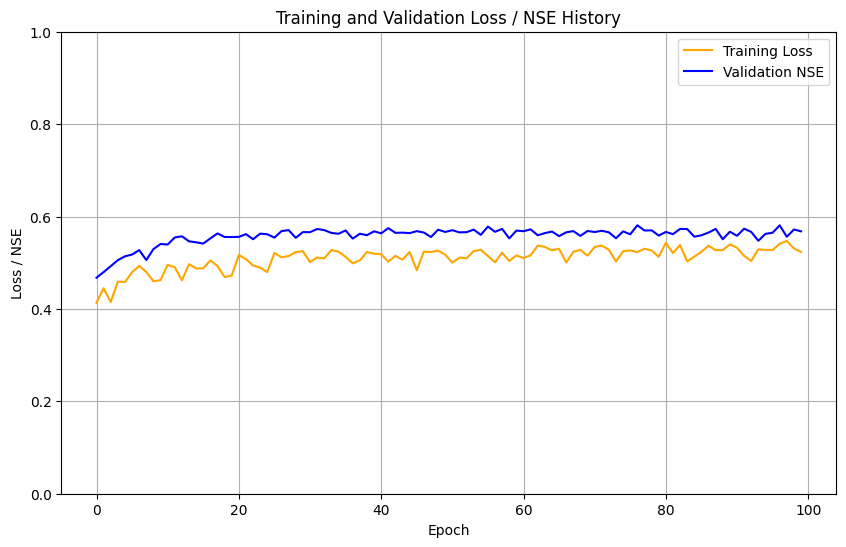

In [11]:
# Plot the training and validation NSE history
plt.figure(figsize=(10, 6))
plt.plot(train_NSE_history_soc, label='Training Loss', color='orange')
plt.plot(val_NSE_history_soc, label='Validation NSE', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss / NSE')
plt.ylim(0, 1)
plt.title('Training and Validation Loss / NSE History')
plt.legend()
plt.grid()
plt.show()


(0.0, 17.16866683959961)

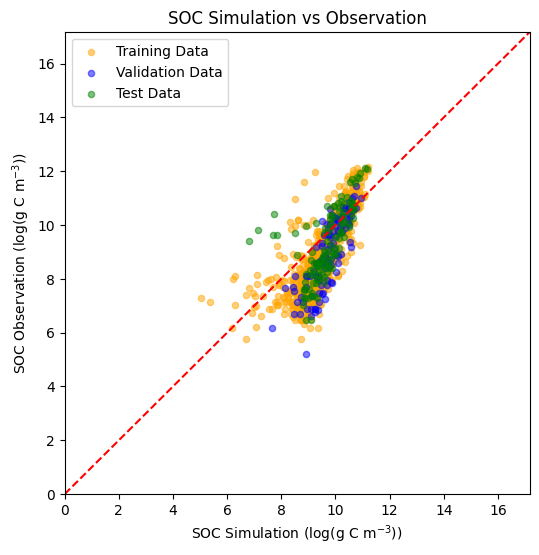

In [12]:
## Scatter plot of SOC simulation vs observation
train_soc_simu = best_guess_train_y_hat[~torch.isnan(best_guess_train_y_hat)]
train_soc_obs = train_y[~torch.isnan(train_y)]
val_soc_simu = best_guess_val_y_hat[~torch.isnan(best_guess_val_y_hat)]
val_soc_obs = val_y[~torch.isnan(val_y)]
test_soc_simu = best_guess_test_y_hat[~torch.isnan(best_guess_test_y_hat)]
test_soc_obs = test_y[~torch.isnan(test_y)]
axis_max = max(train_soc_simu.max(), train_soc_obs.max())
# Log transform the data
train_soc_simu = np.log(train_soc_simu.cpu().numpy() + 1e-10)
train_soc_obs = np.log(train_soc_obs.cpu().numpy() + 1e-10)
val_soc_simu = np.log(val_soc_simu.cpu().numpy() + 1e-10)
val_soc_obs = np.log(val_soc_obs.cpu().numpy() + 1e-10)
test_soc_simu = np.log(test_soc_simu.cpu().numpy() + 1e-10)
test_soc_obs = np.log(test_soc_obs.cpu().numpy() + 1e-10)
axis_max = np.log(axis_max) + 5

plt.figure(figsize=(6, 6))
plt.scatter(train_soc_simu, train_soc_obs, s=20, alpha=0.5, color='orange', label='Training Data')
plt.scatter(val_soc_simu, val_soc_obs, s=20, alpha=0.5, color='blue', label='Validation Data')
plt.scatter(test_soc_simu, test_soc_obs, s=20, alpha=0.5, color='green', label='Test Data')
plt.legend()
plt.plot([0, axis_max], [0, axis_max], color='red', linestyle='--') 
plt.xlabel('SOC Simulation (log(g C m$^{-3}$))')
plt.ylabel('SOC Observation (log(g C m$^{-3}$))')
plt.title('SOC Simulation vs Observation')
plt.xlim(0, axis_max)
plt.ylim(0, axis_max)

## Distribution of the Optimized Parameters
Here we plot the distributions of CLM5 parameters predicted by BINN. Parameters that remain in their initialization value (~0.5) suggest low sensitivity of the SOC simulation to those parameters. By contrast, parameters that deviate from 0.5 —e.g., **q10**, **efolding**, **fs1s2**—appear more influential and better informed by the data. 

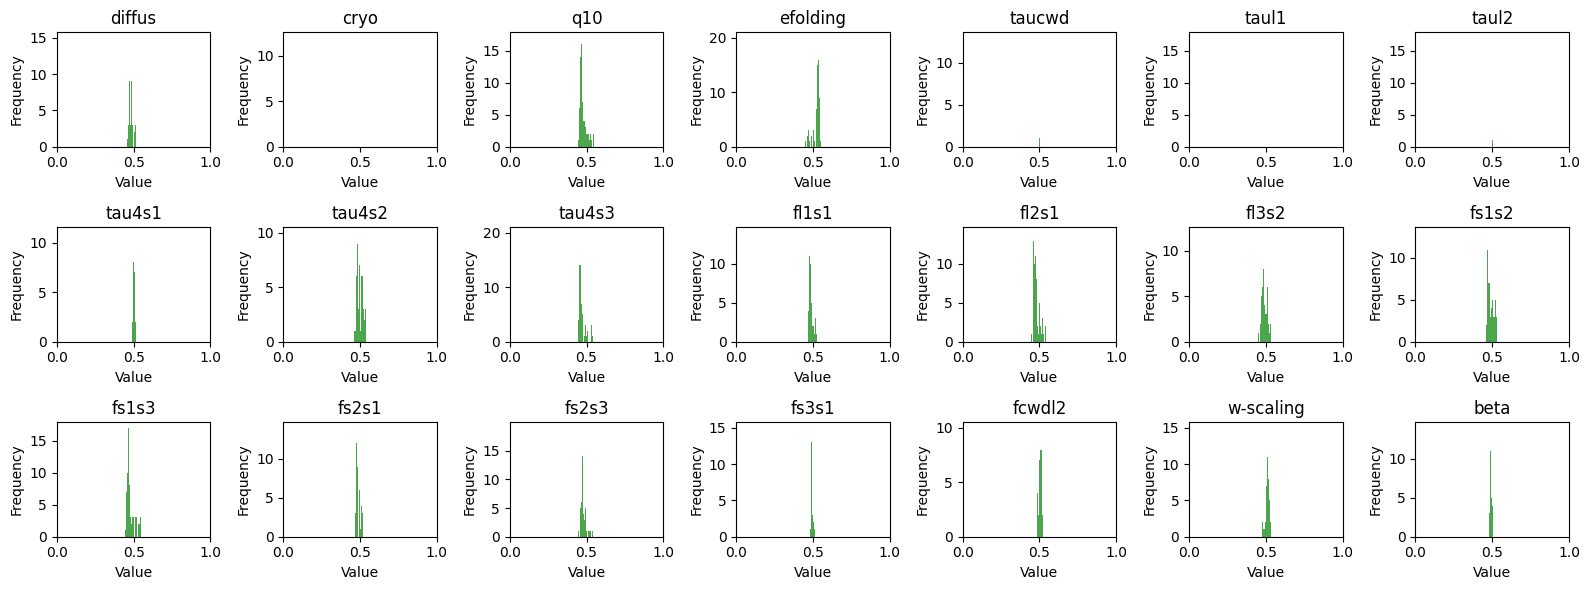

In [13]:
## Distribution of predicted parameters
train_para = best_guess_train_pred_para.cpu().numpy()
val_para = best_guess_val_pred_para.cpu().numpy()
test_para = best_guess_test_pred_para.cpu().numpy()
all_pred_para = np.concatenate((train_para, val_para, test_para), axis=0)

plt.figure(figsize=(16, 6))
for i in range(len(para_names)):
    plt.subplot(3, 7, i + 1)
    plt.hist(all_pred_para[:, i], bins=50, alpha=0.7, color='green')
    plt.title(para_names[i])
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)
plt.tight_layout()
plt.show()

## Bulk Processes Understanding
BINN-optimized parameters are used to construct matrices in the matrix form of CLM5, which can be further used for SOC simulations. In addition, these matrices can be further used for understanding the mechanisms underlying SOC simulations:  
#####  
**Carbon Transfer Efficiency**: the weighted average ratio of decomposed carbon being transferred from one carbon pool to another relative to the total carbon decomposition  
**Baseline Decomposition**: the substrate decomposability of each soil pool  
**Environmental Modifier**: how environment (temperature, moisture, oxygen, and nitrogen) will affect the substrate decomposability  
**Carbon Input Allocation**: how plant carbon being allocated to different soil depths  
**Vertical Transport Rate**: how soil organic carbon moves along the soil depths  
**Plant Carbon Input**: plant carbon input into soil  

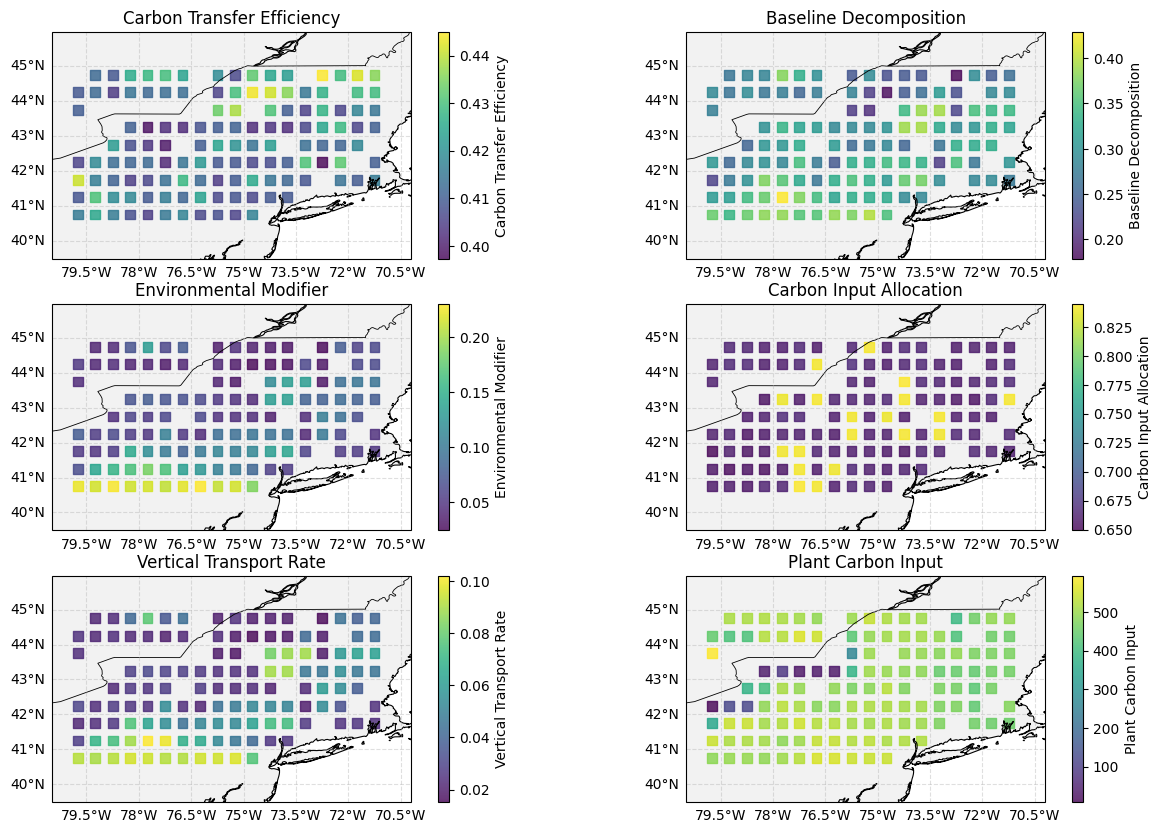

In [14]:
# Bulk prediction with grid data
with torch.no_grad():
    temp_test_soc, temp_test_para = best_guess_model(test_x.to(device), test_z.to(device), whether_predict = 1)
    grid_simu_soc, grid_pred_para = best_guess_model(torch.tensor(predict_data_x, dtype=torch.float32, device=device), torch.tensor(predict_data_z, dtype=torch.float32, device=device), whether_predict = 1)
    
carbon_input_pred, cpool_steady_state_pred, cpools_layer_pred, soc_layer_pred, total_res_time_pred, \
    total_res_time_base_pred, res_time_base_pools_pred, t_scaler_pred, bulk_A_pred, \
    w_scaler_pred, bulk_K_pred, bulk_V_pred, bulk_xi_pred, bulk_I_pred, litter_fraction_pred = fun_bulk_simu(grid_pred_para.to(device), \
                                                                                                    torch.tensor(predict_data_x, dtype=torch.float32, device=device))

# Bulk processes for plotting
bulk_processes = {
    'Carbon Transfer Efficiency': bulk_A_pred,
    'Baseline Decomposition': bulk_K_pred,
    'Environmental Modifier': bulk_xi_pred,
    'Carbon Input Allocation': bulk_I_pred,
    'Vertical Transport Rate': bulk_V_pred,
    'Plant Carbon Input': carbon_input_pred,
}

# Plot the map of the bulk processes using grid_lon and grid_lat
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()
for ax, (process_name, process_data) in zip(axes, bulk_processes.items()):
    ax.set_global()
    ax.add_feature(cfeature.LAND, facecolor='0.95', zorder=0)
    ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=0)
    ax.coastlines(linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.6)
    # Plot the data
    sc = ax.scatter(grid_lon, grid_lat, c=process_data.cpu().numpy(), s=50, marker='s', cmap='viridis', alpha=0.8, transform=ccrs.PlateCarree())
    margin = 1
    ax.set_extent([lons.min()-margin, lons.max()+margin,
                lats.min()-margin, lats.max()+margin],
                crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.4)
    gl.right_labels = False
    gl.top_labels = False
    plt.colorbar(sc, ax=ax, orientation='vertical', label=process_name)
    ax.set_title(process_name)